<a href="https://colab.research.google.com/github/Avalon-DeNecochea/congressionalNotebook/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For this analysis we will look at how many cars are owned within a household. To do so,  . 

First, we will use the American Community Survey 2021 dataset available from census.gov. The data is available via API from here: https://www.census.gov/data/developers/data-sets/acs-1year.html. This data is commonly referenced when people are looking for demographic breakdowns of the American population. This data refers back to the 116th congressional district. 

Second, to get the party affiliation of each congressional district, we will use https://www.house.gov/representatives. Someone has already scraped the house.gov site to turn it into a csv here: http://goodcsv.com/politics/us-house-of-representatives-2020/ for the 116th congressional district.


In [ ]:
# first some initial setup of libraries we will be using
import pandas as pd # this is the main library used in python for manipulating data. 
import json # this is a library to parse json (javascript object notation)
from urllib.request import urlopen # library to read data from a URL
import matplotlib.pyplot as plt # visualization library we will use that integrates with pandas

**Hypothesis:**

We hypothesized people in primarily Republican congressional districts own more cars than people in primarily Democratic congressional districts. 

Generally, Democratic ideas are more environmentally conscious. Also, public transportation is more accepted and supported by Democratic ideals. Combined, we assumed these beliefs could result in owning less cars than Republican. 

First we will read the ACS 2021 dataset and get it into a usable state for our data analysis.

In [ ]:
# We are reading in the data we want from ACS 2021. The API returns json data. Try copy and pasting the link yourself in a browser to see what the raw data looks like.
url="https://api.census.gov/data/2021/acs/acs1?get=NAME,B19001_001E,B19001_002E,B19001_017E,B08141_001E,B08141_002E,B08141_003E,B08141_004E,B08141_005E&for=congressional%20district:*&in=state:*"

# store the response of URL
response = urlopen(url)

# storing the JSON response from url in data
data_json = json.loads(response.read())
data_json.pop(0) # the first row of data is header information which we don't need, so pop removes that from the dataset.

# Hand populate the columns based on the variable descriptions census.gov documents here: https://api.census.gov/data/2021/acs/acs1/variables.html. Note they correspond back to the variable names I included in the URL above.
cols = ['District Name','Total Households','Less than $10k', '$200k+', 'Total', 'No cars', '1 car', '2 cars', '3+ cars', 'State code', 'district number']

acs_df = pd.DataFrame(data_json, columns = cols)

# time to do some basic cleanup of the data. We will need to extract the district number and state in a regular format so we can later join with the party data.
acs_df[['District', 'State']] = acs_df['District Name'].str.split(',', expand=True)
acs_df['district number'] = pd.to_numeric(acs_df['district number'])

acs_df['State'] = acs_df['State'].str.strip()

# Let's just keep the columns we need
acs_df = acs_df[['Total Households', 'Less than $10k', "$200k+", 'Total', 'No cars', '1 car', '2 cars', '3+ cars','district number', 'State']]

# take a look at the top results in the dataset
acs_df.head()

,Total Households,Less than $10k,$200k+,Total,No cars,1 car,2 cars,3+ cars,district number,State
0,289474,14153,19390,335379,7697,51758,140376,135548,10,Michigan
1,299804,23793,10899,323029,8635,54762,140532,119100,4,Mississippi
2,278057,27728,19574,282576,11946,85961,118294,66375,14,Michigan
3,306685,19036,12208,298007,7774,54217,137693,98323,1,Michigan
4,285554,26481,12412,313144,5985,55632,130877,120650,3,Mississippi


In [ ]:

# Convert the number columns into number data types so we can math on them
acs_df["Total Households"] = pd.to_numeric(acs_df["Total Households"])
acs_df["Less than $10k"] = pd.to_numeric(acs_df["Less than $10k"])
acs_df['$200k+'] = pd.to_numeric(acs_df['$200k+'])
acs_df['Total'] = pd.to_numeric(acs_df['Total'])
acs_df['No cars'] = pd.to_numeric(acs_df['No cars'])
acs_df['1 car'] = pd.to_numeric(acs_df['1 car'])
acs_df['2 cars'] = pd.to_numeric(acs_df['2 cars'])
acs_df['3+ cars'] = pd.to_numeric(acs_df['3+ cars'])

# Compute some new columns based on the existing columns for later visualization
acs_df['% of households over $200k'] = (100*acs_df['$200k+'])/acs_df['Total Households']
acs_df['% of households less than $10k'] = (100*acs_df['Less than $10k'])/acs_df['Total Households']
acs_df['% owning no cars'] = (100*acs_df['No cars'])/acs_df['Total']
acs_df['% owning 1 car'] = (100*acs_df['1 car'])/acs_df['Total']
acs_df['% owning 2 cars'] = (100*acs_df['2 cars'])/acs_df['Total']
acs_df['% owning 3+ cars'] = (100*acs_df['3+ cars'])/acs_df['Total']


# now let's look at the data again
acs_df.head()

,Total Households,Less than $10k,$200k+,Total,No cars,1 car,2 cars,3+ cars,district number,State,% of households over $200k,% of households less than $10k,% owning no cars,% owning 1 car,% owning 2 cars,% owning 3+ cars
0,289474,14153,19390,335379,7697,51758,140376,135548,10,Michigan,6.698356,4.889213,2.295015,15.432690,41.855930,40.416365
1,299804,23793,10899,323029,8635,54762,140532,119100,4,Mississippi,3.635375,7.936185,2.673135,16.952658,43.504453,36.869755
2,278057,27728,19574,282576,11946,85961,118294,66375,14,Michigan,7.039564,9.972056,4.227535,30.420489,41.862720,23.489256
3,306685,19036,12208,298007,7774,54217,137693,98323,1,Michigan,3.980632,6.207020,2.608664,18.193197,46.204619,32.993520
4,285554,26481,12412,313144,5985,55632,130877,120650,3,Mississippi,4.346638,9.273552,1.911261,17.765629,41.794510,38.528600


Now let's get our party affiliation data in a state to merge with the ACS data.

In [ ]:
# read from the congressional data and put into a pandas dataframe
party_df = pd.read_csv("http://goodcsv.com/wp-content/uploads/2020/08/us-house-of-representatives-2020.csv", encoding = "ISO-8859-1")

# extract the district number from the data (it was in the format of 5th and we want that to just be 5) using a regular expression.
party_df['district number'] = party_df['District/Position'].str.extract('(\d+)')
party_df['district number'] = party_df['district number'].fillna(0)
party_df['district number'] = pd.to_numeric(party_df['district number'])
party_df['State'] = party_df['State/Territory']
party_df['State'] = party_df['State'].str.strip()
party_df['Party'] = party_df['Party'].str.strip() # remove extraneous whitespace

# Let's just keep the columns we need
party_df = party_df[['State', 'Party', "district number"]]

party_df.head(5)

,State,Party,district number
0,Louisiana,R,5
1,North Carolina,D,12
2,Alabama,R,4
3,California,D,31
4,Georgia,R,12


Let's pull some statistics on the two datasets quickly before we join them so we can sanity check that the join worked ok.

In [ ]:
party_df['State'].value_counts()

California                  53
Texas                       36
New York                    27
Florida                     27
Pennsylvania                18
Illinois                    18
Ohio                        16
Michigan                    14
Georgia                     14
North Carolina              13
New Jersey                  12
Virginia                    11
Washington                  10
Indiana                      9
Arizona                      9
Tennessee                    9
Massachusetts                9
Minnesota                    8
Missouri                     8
Maryland                     8
Wisconsin                    8
Colorado                     7
Alabama                      7
South Carolina               7
Louisiana                    6
Kentucky                     6
Oklahoma                     5
Oregon                       5
Connecticut                  5
Nevada                       4
Kansas                       4
Arkansas                     4
Iowa    

In [ ]:
acs_df['State'].value_counts()

California              53
Texas                   36
Florida                 27
New York                27
Illinois                18
Pennsylvania            18
Ohio                    16
Georgia                 14
Michigan                14
North Carolina          13
New Jersey              12
Virginia                11
Washington              10
Indiana                  9
Massachusetts            9
Arizona                  9
Tennessee                9
Missouri                 8
Wisconsin                8
Minnesota                8
Maryland                 8
South Carolina           7
Alabama                  7
Colorado                 7
Kentucky                 6
Louisiana                6
Connecticut              5
Oklahoma                 5
Oregon                   5
Iowa                     4
Kansas                   4
Arkansas                 4
Mississippi              4
Nevada                   4
Utah                     4
New Mexico               3
West Virginia            3
N

So the ACS dataset has stats for DC and Puerto Rico. The party datset has other terratories like the Virgin Islands. The state counts look right though. Let's go ahead and merge.

In [ ]:
# Merge is like a sql natural join. We are joining on the State and District numbers being the same between the two sets.
# pd.merge is like inner join
merged_df = pd.merge(acs_df, party_df, on=["State", "district number"])

In [ ]:
merged_df.describe()

,Total Households,Less than $10k,$200k+,Total,No cars,1 car,2 cars,3+ cars,district number,% of households over $200k,% of households less than $10k,% owning no cars,% owning 1 car,% owning 2 cars,% owning 3+ cars
count,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000
mean,292471.643678,17605.977011,28522.944828,350680.891954,14280.714943,71853.126437,141910.751724,122636.298851,10.158621,9.721602,6.050237,4.154695,20.504986,40.263633,35.076686
std,33670.787672,6047.931263,18902.411362,48039.605890,25196.342040,24485.693613,32061.621642,34315.685249,10.656779,6.417955,2.106075,7.549963,6.310137,6.095789,9.056588
min,183319.000000,6021.000000,5296.000000,193479.000000,2980.000000,32464.000000,11180.000000,2837.000000,0.000000,2.025905,2.208934,0.865165,9.027583,3.676688,0.697869
25%,273747.000000,13416.000000,14916.000000,321308.500000,6598.500000,55509.000000,122897.500000,107182.500000,3.000000,5.184740,4.653305,1.917412,16.337967,38.138192,30.885122
50%,292311.000000,16617.000000,22543.000000,349657.000000,8164.000000,65376.000000,141915.000000,124099.000000,6.000000,7.618205,5.679285,2.367409,19.063042,41.336686,36.118185
75%,311849.500000,21013.500000,37009.500000,377558.500000,12187.000000,82890.500000,162347.000000,141357.000000,13.000000,12.689262,7.036059,3.502310,22.972174,43.744181,40.839458
max,448949.000000,44929.000000,111988.000000,515268.000000,263645.000000,173036.000000,238465.000000,236074.000000,53.000000,41.846370,16.858153,65.170121,45.376100,50.069389,58.884783


There are 435 total rows, which matches up with the number of congress members in the 116th congress. Looks pretty good. Let's do a final check by looking at party counts.

In [ ]:
# let's take a look at the party breakdown and sanity check that it looks right
merged_df['Party'].value_counts()

D    233
R    201
L      1
Name: Party, dtype: int64

Let's do our visualization now. We will do a scatter plot of congressional districts and look at the % of households earning over \$200k on one axis and % of households less than $10k on the other axis. We will color the plot based upon the party affiliation of the districts congress member as of the 116th congress.

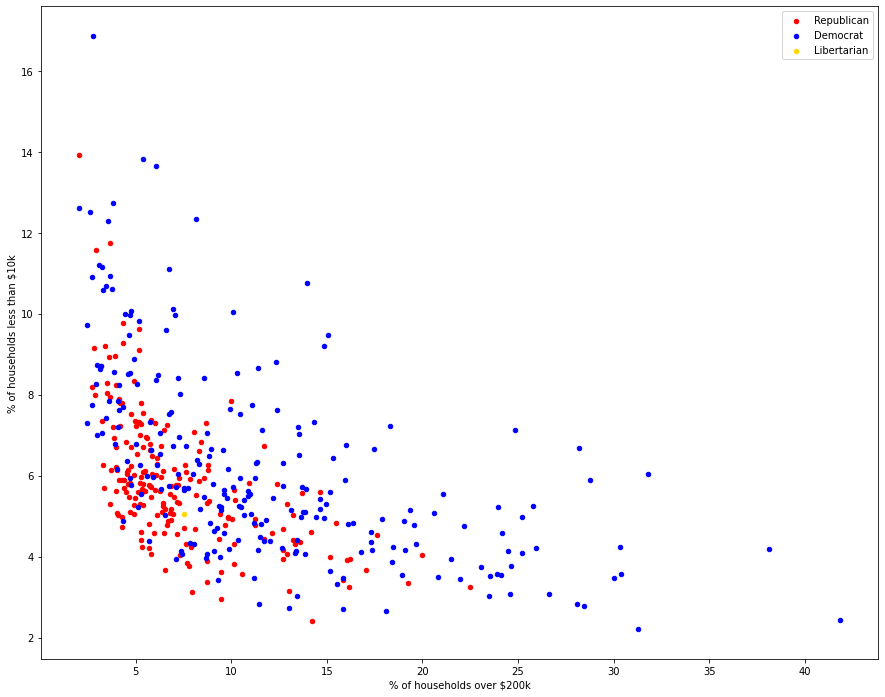

In [ ]:
R = merged_df[merged_df['Party'].str.contains('R')]
D = merged_df[merged_df['Party'].str.contains('D')]
L = merged_df[merged_df['Party'].str.contains('L')]

fig, ax = plt.subplots(figsize=(15, 12))
R.plot.scatter(x='% of households over $200k', y='% of households less than $10k', c='red',label='Republican', ax=ax)
D.plot.scatter(x='% of households over $200k', y='% of households less than $10k',c='blue',label='Democrat', ax=ax)
L.plot.scatter(x='% of households over $200k', y='% of households less than $10k',c='gold',label='Libertarian', ax=ax)

#for i, txt in enumerate(df['State']):
#   ax.annotate(txt, (df['% of households over $200k'].iat[i], df['% of households less than $10k'].iat[i]))

plt.legend()
plt.show()

For our second visual we continued with the scatterplot but this time looked at the % of owning no cars(y axis) and percentage of owning 3+ cars(x axis).  The plot is still colored by political affilitation.  We can see by looking at the visual that democrats % are higher when it comes to owning no cars compared to republicans being heavier on owning 3+ cars.  This further supports our hypothesis that liberals would own less cars because they are environmentally conscious. 

In [ ]:
merged_df.to_csv("congressional_district_with_parties.csv")

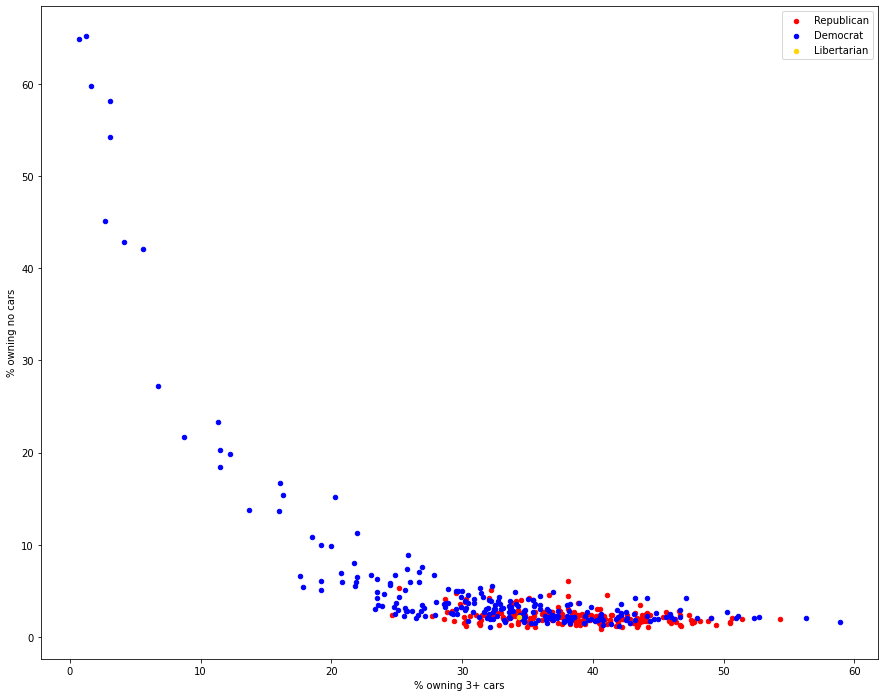

In [ ]:
  R = merged_df[merged_df['Party'].str.contains('R')]
D = merged_df[merged_df['Party'].str.contains('D')]
L = merged_df[merged_df['Party'].str.contains('L')]

fig, ax = plt.subplots(figsize=(15, 12))
R.plot.scatter(x='% owning 3+ cars', y='% owning no cars', c='red',label='Republican', ax=ax)
D.plot.scatter(x='% owning 3+ cars', y='% owning no cars',c='blue',label='Democrat', ax=ax)
L.plot.scatter(x='% owning 3+ cars', y='% owning no cars',c='gold',label='Libertarian', ax=ax)

#for i, txt in enumerate(df['State']):
#   ax.annotate(txt, (df['% of households over $200k'].iat[i], df['% of households less than $10k'].iat[i]))

plt.legend()
plt.show()

On this scatterplot we decided to also include the % of owning no cars(y axis) and percentage of owning 1 car(x axis). To see if we could notice a different trend here. But still noticed that Republicans still have a low % when it comes to owning no cars or even 1 car. 

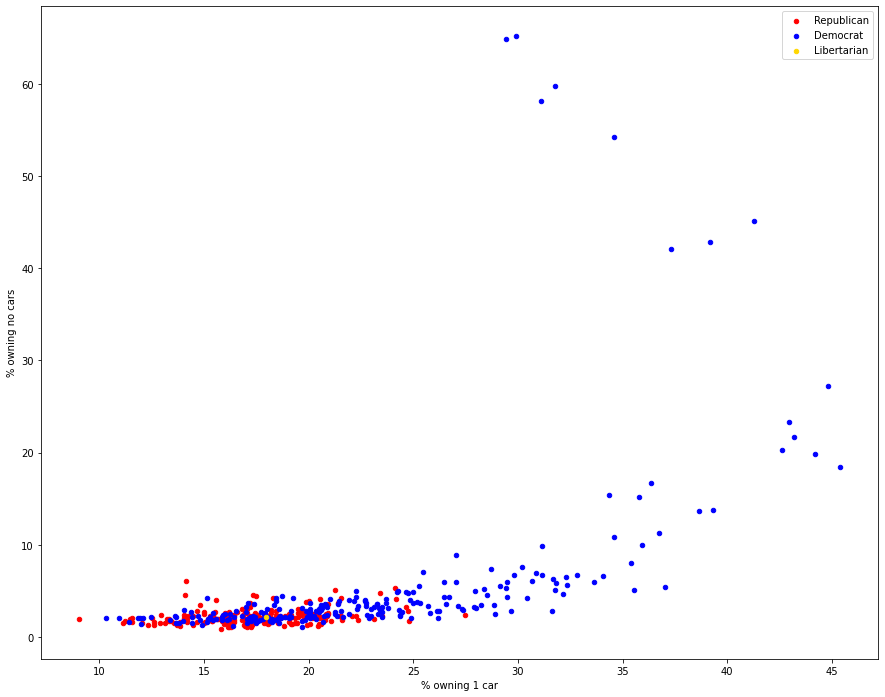

In [ ]:
R = merged_df[merged_df['Party'].str.contains('R')]
D = merged_df[merged_df['Party'].str.contains('D')]
L = merged_df[merged_df['Party'].str.contains('L')]

fig, ax = plt.subplots(figsize=(15, 12))
R.plot.scatter(x='% owning 1 car', y='% owning no cars', c='red',label='Republican', ax=ax)
D.plot.scatter(x='% owning 1 car', y='% owning no cars',c='blue',label='Democrat', ax=ax)
L.plot.scatter(x='% owning 1 car', y='% owning no cars',c='gold',label='Libertarian', ax=ax)

#for i, txt in enumerate(df['State']):
#   ax.annotate(txt, (df['% of households over $200k'].iat[i], df['% of households less than $10k'].iat[i]))

plt.legend()
plt.show()

On this scatterplot showing % that own 1 car (y axis) and owning 2 cars (x axis) we can start to notice that both parties seem to be fairly similar when it comes to owning 2 cars with democrats swaying to a lower % but we can also still notice that Democrats tend to lean more to owning less cars then Republicans tend to.

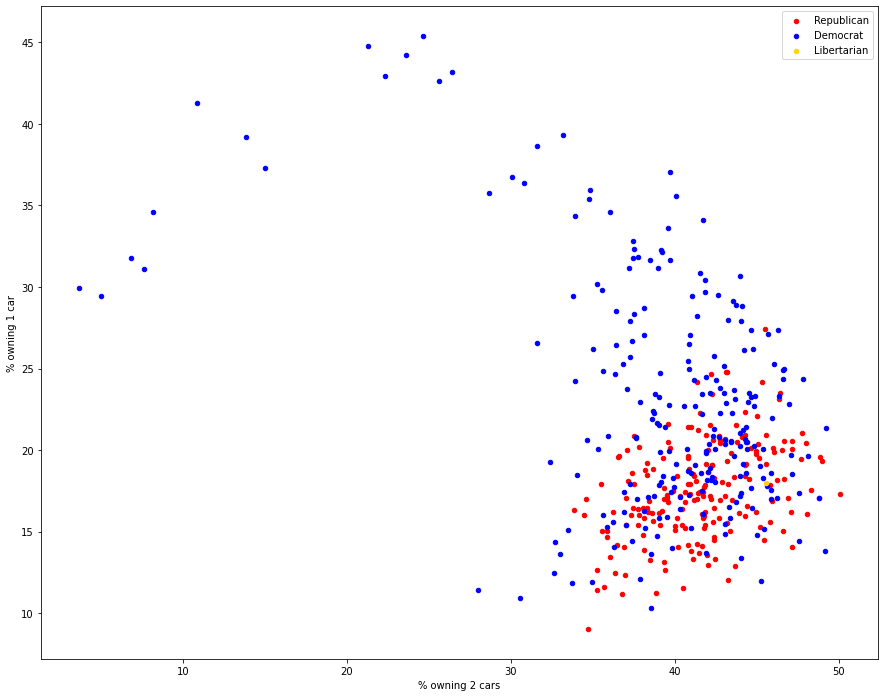

In [ ]:
R = merged_df[merged_df['Party'].str.contains('R')]
D = merged_df[merged_df['Party'].str.contains('D')]
L = merged_df[merged_df['Party'].str.contains('L')]

fig, ax = plt.subplots(figsize=(15, 12))
R.plot.scatter(x='% owning 2 cars', y='% owning 1 car', c='red',label='Republican', ax=ax)
D.plot.scatter(x='% owning 2 cars', y='% owning 1 car',c='blue',label='Democrat', ax=ax)
L.plot.scatter(x='% owning 2 cars', y='% owning 1 car',c='gold',label='Libertarian', ax=ax)

#for i, txt in enumerate(df['State']):
#   ax.annotate(txt, (df['% of households over $200k'].iat[i], df['% of households less than $10k'].iat[i]))

plt.legend()
plt.show()

On this final visual we looked at is % who own 2 cars (y axis) and % who own 3 or more cars(x axis) we found that Democrats had more variety across the graph while Republicans are in the high %'s for both 2 cars and 3 or more cars.  

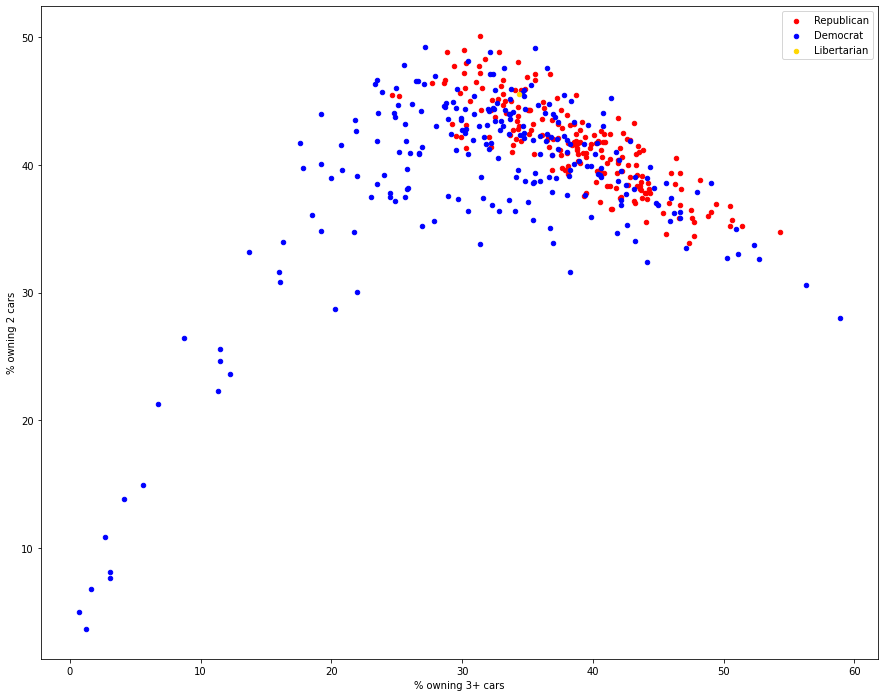

In [ ]:
R = merged_df[merged_df['Party'].str.contains('R')]
D = merged_df[merged_df['Party'].str.contains('D')]
L = merged_df[merged_df['Party'].str.contains('L')]

fig, ax = plt.subplots(figsize=(15, 12))
R.plot.scatter(x='% owning 3+ cars', y='% owning 2 cars', c='red',label='Republican', ax=ax)
D.plot.scatter(x='% owning 3+ cars', y='% owning 2 cars',c='blue',label='Democrat', ax=ax)
L.plot.scatter(x='% owning 3+ cars', y='% owning 2 cars',c='gold',label='Libertarian', ax=ax)

#for i, txt in enumerate(df['State']):
#   ax.annotate(txt, (df['% of households over $200k'].iat[i], df['% of households less than $10k'].iat[i]))

plt.legend()
plt.show()

**Conclusion:**

Ultimately, these graphs support our hypothesis that Republicans will own more cars than Democrats.